In [5]:
import pnadc #to install, run pip install git+https://github.com/AlanGanem/pnadc
from tqdm import tqdm
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

%matplotlib inline

In [6]:
paths_2020 = [*Path('../data/').glob('*2020.csv')]

In [7]:
#download if needed
if not paths_2020:
    pnadc.get_all([2020], path = 'pnadpy/', protocol = 'https')
    paths_2020 = [*Path('../data/').glob('*2020.csv')]

In [8]:
def convert_int(df, dtype = int, nan_fill = -1, valid_range = (0,100)):
    '''
    checks the columns that are composed of only integers, if so, cast to dtype (defaults to int, but could be also str or float)
    '''
    if df.__class__ == dd.DataFrame:
        return df.map_partitions(convert_int)
    
    for col in df.columns:
        if (df[col].dropna() == df[col].dropna().values.astype(int)).all():
            if not valid_range is None:
                if all(df[col].between(*valid_range)):
                    df[col] = df[col].fillna(nan_fill).astype(dtype)
                    
                    if dtype in ['str',str]:
                        df[col] = df[col].str.replace('.0', '')
            else:
                df[col] = df[col].fillna(nan_fill).astype(dtype)
                if dtype in ['str',str]:
                    df[col] = df[col].str.replace('.0', '')
            
            
                                                       
    return df

def rename_variables_pnadc(df, pnadc_dictionary_path):    
    return

def load_pnadc_dict_dataframe(dict_path_excel = r'..\data\dicionario_PNADC_microdados_trimestral.xls'):
    dic = pd.read_excel(dict_path_excel)
    dic = dic.fillna(method = 'ffill').set_index(['Código da variável'])
    return dic 

def load_cnae_codes(cnaes_path = r'..\data\Estrutura_Atividade_CNAE_Domiciliar_2_0.xls'):
    cnaes = pd.read_excel(cnaes_path)
    cnaes = cnaes.fillna(method = 'ffill')
    
    def _custom_dedup(df):
        d = {}
        d['Divisão'] = df['Divisão'].iloc[0]
        d['Seção'] = df['Seção'].iloc[0]
        d['Denominação'] = df['Denominação'].values.tolist()
        return pd.Series(d)
    
    cnaes = cnaes.groupby('Classe').apply(_custom_dedup).reset_index()   
    cnaes = cnaes.rename(
        columns = {
            'Seção':'V4013-Sec',
            'Divisão' : 'V4013-Div',
            'Classe' : 'V4013',
            'Denominação':'V4013-Name'             
        }
    )
    

    return cnaes

def create_parquet_pnadc(path, saving_path = 'PNADC/pnadc_compiled.parquet'):
    with ProgressBar():
        data = dd.read_csv(path)
        data = data.repartition('100MB').drop_duplicates()
        data.to_parquet(saving_path)
    return saving_path

# Load Data and vars dict

In [231]:
ocupacao = pd.read_excel(r'..\data\Estrutura_Ocupacao_COD.xls').fillna(method = 'ffill')

In [10]:
cnaes = load_cnae_codes()

In [11]:
var_dict = load_pnadc_dict_dataframe()

In [12]:
var_dict.loc['UF']

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
UF,6.0,2.0,NaN,Unidade da Federação,11,Rondônia,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,12,Acre,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,13,Amazonas,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,14,Roraima,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,15,Pará,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,16,Amapá,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,17,Tocantins,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,21,Maranhão,1º tri/2012 - atual,Parte 1 - Identificação e Controle
UF,6.0,2.0,NaN,Unidade da Federação,22,Piauí,1º tri/2012 - atual,Parte 1 - Identificação e Controle


In [13]:
#create_parquet_pnadc(path = 'PNADC/*.csv')
data = dd.read_csv(paths_2020)
#filters
#ref https://rpubs.com/nataliarspires/Tutorial_PNADC_23SINAPE
data = data.query('V2009 >= 14 and VD4015 == 1') #maiores de 14 anos e trabalho remunerado

In [14]:
data = data.compute() #compute filtered data

In [15]:
data.shape[0]

592844

In [16]:
#data = data.astype(str)
#data = convert_int(data, dtype = str)


In [17]:
#var_dict.loc[rendimentos_cols]

In [18]:
var_dict.query('`Categorias Descrição` == "R$"')

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
V403312,188.0,8.0,33,Qual era o rendimento bruto/retirada mensal qu...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V403322,198.0,8.0,33,Qual era o rendimento bruto/retirada mensal qu...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V403412,211.0,8.0,34,Qual foi o rendimento bruto/retirada que ... r...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V403422,221.0,8.0,34,Qual foi o rendimento bruto/retirada que ... r...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405012,261.0,8.0,50,Valor em dinheiro do rendimento mensal que rec...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405022,271.0,8.0,50,Valor estimado dos produtos e mercadorias que ...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405112,284.0,8.0,51,Valor em dinheiro do rendimento mensal que rec...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405122,294.0,8.0,51,Valor estimado dos produtos e mercadorias que ...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas
V405812,312.0,8.0,58,Valor em dinheiro do rendimento mensal que rec...,valor em reais,R$,1º tri/2012 - atual,2 - Pessoas Ocupadas


In [19]:
rendimentos_cols = [
    'VD4016' 
]

In [20]:
rendimentos = data[rendimentos_cols]

In [21]:
(rendimentos == 0).mean()

VD4016    0.0
dtype: float64

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'wage in R$')

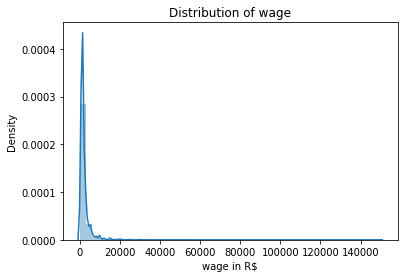

In [22]:
sns.distplot(rendimentos.sample(frac = 0.2))
plt.title('Distribution of wage')
plt.xlabel('wage in R$')

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'ln(wage) in R$')

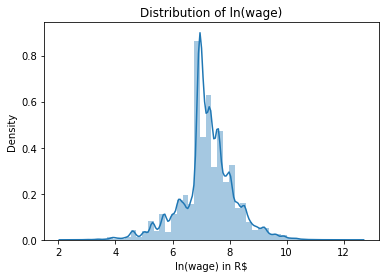

In [23]:
sns.distplot(np.log(rendimentos.sample(frac = 0.2)))
plt.title('Distribution of ln(wage)')
plt.xlabel('ln(wage) in R$')

In [24]:
var_dict.loc['V2010']

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
V2010,95.0,1.0,10,Cor ou raça,1,Branca,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,2,Preta,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,3,Amarela,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,4,Parda,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,5,Indígena,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores
V2010,95.0,1.0,10,Cor ou raça,9,Ignorado,1º tri/2012 - atual,Parte 2 - Características Gerais dos Moradores


In [25]:
raca = data['V2010']

raca.value_counts(1)

4.0    0.476840
1.0    0.424537
2.0    0.089572
3.0    0.005118
5.0    0.003760
9.0    0.000174
Name: V2010, dtype: float64

In [26]:
raca_binary = data['V2010']
sex = data['V2007']

In [27]:
sex.loc[sex == 1] = 'Masculino'
sex.loc[sex == 2] = 'Feminino'

In [28]:
raca_binary.loc[raca_binary.isin([9])] = 'Ignorado'
raca_binary.loc[raca_binary.isin([1,3])] = 'Branca ou Amarela'
raca_binary.loc[raca_binary.isin([2,4,5])] = 'Preta, Parda ou Indígena'

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [29]:
pd.concat([raca_binary,rendimentos, sex], axis = 1).groupby(['V2007','V2010'])['VD4016'].describe()

count         mean           std  \
V2007     V2010                                                           
Feminino  Branca ou Amarela         110010.0  2434.984347   3191.328347   
          Ignorado                      44.0  1851.136364   1553.666655   
          Preta, Parda ou Indígena  133719.0  1495.233953   1776.013659   
Masculino Branca ou Amarela         144708.0  3089.524352   4748.443123   
          Ignorado                      59.0  5734.915254  13741.702998   
          Preta, Parda ou Indígena  204304.0  1783.314262   2312.968669   

                                      min     25%     50%     75%       max  
V2007     V2010                                                              
Feminino  Branca ou Amarela           8.0  1045.0  1500.0  2665.5  100000.0  
          Ignorado                  150.0   800.0  1237.5  2275.0    6500.0  
          Preta, Parda ou Indígena   10.0   700.0  1045.0  1600.0  100000.0  
Masculino Branca ou Amarela          10.0  1100.0  1885.0  3000.0  250000.0  
          Ignorado                  400.0  1045.0  1500.0  3000.0   60000.0  
          Preta, Parda ou Indígena    4.0   900.0  1200.0  2000.0  100000.0

# Feature engineering

In [30]:
ocupacao#['Grupo de base']
#data['V4010']

,Grande Grupo,Subgrupo principal,Subgrupo,Grupo de base,Denominação
0,1.0,NaN,NaN,NaN,DIRETORES E GERENTES
1,1.0,11.0,NaN,NaN,"DIRETORES EXECUTIVOS, DIRIGENTES DA ADMINISTRA..."
2,1.0,11.0,111.0,NaN,Membros superiores do poder executivo e legisl...
3,1.0,11.0,111.0,1111.0,Legisladores
4,1.0,11.0,111.0,1112.0,Dirigentes superiores da administração pública
...,...,...,...,...,...
609,0.0,4.0,41.0,412.0,Graduados e praças da polícia militar
610,0.0,5.0,41.0,412.0,BOMBEIROS MILITARES
611,0.0,5.0,51.0,412.0,Bombeiros militares
612,0.0,5.0,51.0,511.0,Oficiais de bombeiro militar


In [31]:
data = data.merge(ocupacao.drop_duplicates(subset = ['Grupo de base']), left_on = 'V4010', right_on = 'Grupo de base', how = 'left', validate = 'm:1')

In [32]:
data = data.merge(cnaes[['V4013', 'V4013-Div', 'V4013-Sec', 'V4013-Name']], how = 'left', on = 'V4013', validate = 'm:1') ## CNAE-Section of sector of the job

In [33]:

data['V4010-SubP'] = data['Subgrupo principal'].astype(str) #subgrupo principal of ocupation according to Estrutura_Ocupacao_COD
data['V4010-Sub'] = data['Subgrupo'].astype(str)
data['V4013-Div'] = data['V4013-Div'].astype(str)


data['VD4016-Log'] = np.log(data['VD4016']) #wage log



In [34]:
data['V2010-Bin'] = raca_binary.values
data['V2007-Bin'] = sex.values


In [35]:
#filter out rows where race is empty
data = data[data['V2010-Bin'] != 'Ignorado']

# Finding Confounders

Confounders are good predictors of both the treatment and the observed outcome.
Knowing what are these variables are usefull because in order to remove bias we have to control for confounders

In [36]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, RobustScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, r2_score

In [37]:
def PredictionTransformerWrapper(estimator, transform_method = 'apply'):
    '''
    factory to allow specific methods to be exposed as a transform method,
    allowing its usage in sklearn pipelines
    '''
    class PredictionTransformer(estimator):        
        def transform(self, X, **kwargs):
            return getattr(self, transform_method)(X, **kwargs)

class RobustEncoder(BaseEstimator, TransformerMixin):

    def __init__(self,):
        '''
        A robust one hot encoder. Always return the same amount of nonzero value sin each transformed row.
        Has columns for unknown values
        '''
        return

    def fit(self, X, y = None, **kwargs):
        X = np.array(X)
        X = X.astype(str)
        
        self.ordinalencoder_ = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1).fit(X)
        X = self.ordinalencoder_.transform(X)
        
        categories = [np.arange(-1, len(cats)) for cats in self.ordinalencoder_.categories_]        
        self.onehotencoder_ = OneHotEncoder(categories = categories, drop = 'first', **kwargs).fit(X)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = X.astype(str)
        X = self.ordinalencoder_.transform(X)
        return self.onehotencoder_.transform(X)
    
def make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns, final_estimator = None):
    
    pipe = ColumnTransformer(
        [
            ('OneHotEncoder', RobustEncoder(), categorical_columns),
            ('NumericalPassthrough', RobustScaler(), numerical_columns),            
        ]
    )
    
    if not final_estimator is None:
        pipe = Pipeline(
            [
                ('PreprocessingPipeline', pipe),
                ('FinalEstimator', final_estimator)
            ]
        )
        
    return pipe

## Feature Importances

### First run

In [443]:
categorical_columns = [
    'UF', #estado
    'V1022', #zona rural ou urbana
    'V1023', # região do estado    
    'V3001', #sabe ler ou escrever?
    'V4010-SubP', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4010-Sub', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4012', #Nesse trabalho,... era
    'V4013-Sec', #seção do código CNAE da principal atividade do trabalho
    'V4013-Div', #Divisão do código CNAE da principal atividade do trabalho
    'V4014', #esfera do trabalho (Federal estadual ou municipal)
    'VD3004', #nível de instrução mais elevado alcançado
    'V3009A', #curso mais alto que frequentou anteriormente
    'V4029', #carteira assinada    
    #'VD4032', #Horas efetivamente trabalhadas na semana de referência no trabalho principal para pessoas de 14 anos ou mais de idade    
]


numerical_columns = [
    'V2009', #idade
    'VD3005', #anos de estudo
    'VD4013', #Faixa das horas habitualmente trabalhadas
]

treatment_columns = [
    'V2007-Bin', #sexo
    'V2010-Bin', #cor ou raça binária (branco ou amarelo/ preto pardo ou indigena)
]

target_columns = [
    'VD4016-Log', #Rendimento mensal habitual do trabalho principal para pessoas de 14 anos ou mais de idade (apenas para pessoas que receberam em dinheiro, produtos ou mercadorias no trabalho principal)
]

X_columns = categorical_columns + numerical_columns
T_columns = treatment_columns
y_columns = target_columns


In [444]:
train_frac = 0.8
train_idxs = np.random.choice(range(len(data)), size = int(len(data)*train_frac), replace = False)

train_msk = np.empty((len(data),), dtype = bool)
train_msk[:] = False
train_msk[train_idxs] = True
test_msk = ~train_msk

In [445]:
#estim = RandomForestRegressor(20, criterion = 'absolute_error', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
estim = RandomForestClassifier(50, criterion = 'gini', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_treatment = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [446]:
pipe_treatment.fit(data[X_columns][train_msk], data[T_columns[0]][train_msk])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V4010-SubP',
                                                   'V4010-Sub', 'V4012',
                                                   'V4013-Sec', 'V4013-Div',
                                                   'V4014', 'VD3004', 'V3009A',
                                                   'V4029', 'VD4013']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x0000021045950670>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 Rand

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


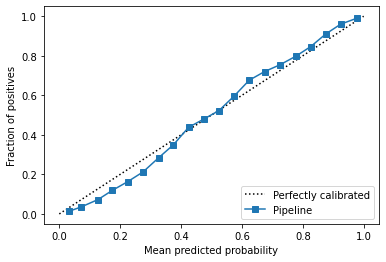

In [447]:
from sklearn.calibration import CalibrationDisplay
display = CalibrationDisplay.from_estimator(
    pipe_treatment,
    data[X_columns][test_msk],
    data[T_columns[0]][test_msk],
    n_bins=20,
)

In [448]:
def auc_scoring(estim, X, y):
    return roc_auc_score(OneHotEncoder(sparse = False).fit_transform(y), estim.predict_proba(X), multi_class = 'ovr')

importances = permutation_importance(pipe_treatment, data[X_columns][test_msk], data[[T_columns[0]]][test_msk], n_repeats = 10, n_jobs = -1, scoring = auc_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


In [449]:
auc_scoring(pipe_treatment, data[X_columns][test_msk], data[[T_columns[0]]][test_msk])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished

The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The MathtextBackendBitmap class was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.


<AxesSubplot:xlabel='value', ylabel='feature'>

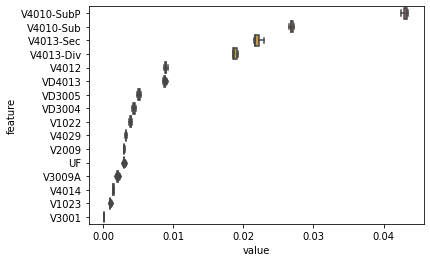

In [450]:
importances_df = pd.DataFrame(importances['importances'])
importances_df['feature'] = X_columns
importances_df = importances_df.melt(id_vars = ['feature'], var_name = 'iter')
rank = importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=importances_df,
            order = rank.index 
           )
#plt.legend()

Podemos ver que existe uma associação forte entre variáveis referentes ao tipo de trabalho e o recorte racial.
Isso pode ser um problema, no sentido em que essas variáveis são [mediadores](https://en.wikipedia.org/wiki/Mediation_(statistics)#Direct_versus_indirect_effects). Por exemplo: o racismo estrutural faz com que pessoas de mesma qualificação não consiga cargos gerenciais e de liderança, ou empregos npor exemplo etc.

Por isso, serão omitidas as variáveis referentes à natureza da ocupação (Exceto a parte que diz respeito o setor do trabalho pelo CNAE), para evitar viés de seleção através do controle de mediadores ('V4010', 'V4013', 'V4012', 'V4014').

é interessante porque isso já antecipa o viés que pode ser encontrado quando for feita a regressão do salário utilizando as mesmas variáveis

### Second run

In [451]:
categorical_columns = [
    'UF', #estado
    'V1022', #zona rural ou urbana
    'V1023', # região do estado    
    'V3001', #sabe ler ou escrever?
    'V4010-SubP', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4010-Sub', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4012', #Nesse trabalho,... era
    'V4013-Sec', #seção do código CNAE da principal atividade do trabalho
    'V4013-Div', #Divisão do código CNAE da principal atividade do trabalho
    'V4014', #esfera do trabalho (Federal estadual ou municipal)
    'VD3004', #nível de instrução mais elevado alcançado
    'V3009A', #curso mais alto que frequentou anteriormente
    'V4029', #carteira assinada    
    #'VD4032', #Horas efetivamente trabalhadas na semana de referência no trabalho principal para pessoas de 14 anos ou mais de idade    
]


numerical_columns = [
    'V2009', #idade
    'VD3005', #anos de estudo
    'VD4013', #Faixa das horas habitualmente trabalhadas
]

treatment_columns = [
    'V2007-Bin', #sexo
    'V2010-Bin', #cor ou raça binária (branco ou amarelo/ preto pardo ou indigena)
]

target_columns = [
    'VD4016-Log', #Rendimento mensal habitual do trabalho principal para pessoas de 14 anos ou mais de idade (apenas para pessoas que receberam em dinheiro, produtos ou mercadorias no trabalho principal)
]

X_columns = categorical_columns + numerical_columns
T_columns = treatment_columns
y_columns = target_columns


In [452]:
train_frac = 0.8
train_idxs = np.random.choice(range(len(data)), size = int(len(data)*train_frac), replace = False)

train_msk = np.empty((len(data),), dtype = bool)
train_msk[:] = False
train_msk[train_idxs] = True
test_msk = ~train_msk

#### Sex Prediction

In [453]:
#estim = RandomForestRegressor(20, criterion = 'absolute_error', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
estim = RandomForestClassifier(50, criterion = 'gini', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_sex = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [454]:
pipe_sex.fit(data[X_columns][train_msk], data[T_columns[0]][train_msk])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V4010-SubP',
                                                   'V4010-Sub', 'V4012',
                                                   'V4013-Sec', 'V4013-Div',
                                                   'V4014', 'VD3004', 'V3009A',
                                                   'V4029', 'VD4013']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x0000020FBE51A8B0>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 Rand

In [4]:
from sklearn.calibration import CalibrationDisplay
display = CalibrationDisplay.from_estimator(
    pipe_sex,
    data[X_columns][test_msk],
    data[T_columns[0]][test_msk],
    n_bins=20,
)

NameError: name 'pipe_sex' is not defined

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

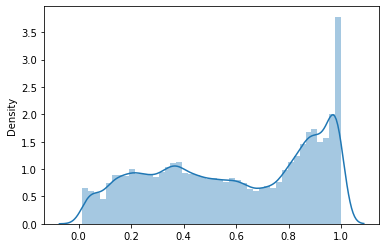

In [456]:
sns.distplot(pipe_sex.predict_proba(data[X_columns][test_msk])[:,1])

In [457]:
sex_auc = auc_scoring(pipe_sex, data[X_columns][train_msk], data[[T_columns[0]]][train_msk])
(
    auc_scoring(pipe_sex, data[X_columns][train_msk], data[[T_columns[0]]][train_msk]),
    auc_scoring(pipe_sex, data[X_columns][test_msk], data[[T_columns[0]]][test_msk])
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished

The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases 

In [458]:
sex_importances = permutation_importance(pipe_sex, data[X_columns][test_msk], data[[T_columns[0]]][test_msk], n_repeats = 10, n_jobs = -1, scoring = auc_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


Text(0.5, 1.0, 'Permutation feature importances for sex prediction (AUC = 0.89)')

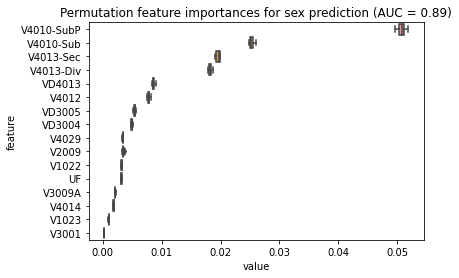

In [459]:
sex_importances_df = pd.DataFrame(sex_importances['importances'])
sex_importances_df['feature'] = X_columns
sex_importances_df = sex_importances_df.melt(id_vars = ['feature'], var_name = 'iter')
sex_rank = sex_importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=sex_importances_df,
            order = sex_rank.index 
           )
plt.title(f'Permutation feature importances for sex prediction (AUC = {round(sex_auc,2)})')
#plt.legend()

In [460]:
#var_dict.loc[[i.replace('-Sec', '').replace('-SubP','') for i in sex_rank.index]].reset_index().drop_duplicates(var_dict.index.name)

Podemos ver que o efeito é mais moderado nesses potenciais confundidores.

#### Race Prediction

In [461]:
#estim = RandomForestRegressor(20, criterion = 'absolute_error', min_samples_leaf = 20, oob_score = True, n_jobs = -1, verbose = 1)
estim = RandomForestClassifier(50, criterion = 'gini', min_samples_leaf = 10, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_race = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [462]:
pipe_race.fit(data[X_columns][train_msk], data[T_columns[1]][train_msk])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V4010-SubP',
                                                   'V4010-Sub', 'V4012',
                                                   'V4013-Sec', 'V4013-Div',
                                                   'V4014', 'VD3004', 'V3009A',
                                                   'V4029', 'VD4013']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x0000020FBE541040>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 Rand

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


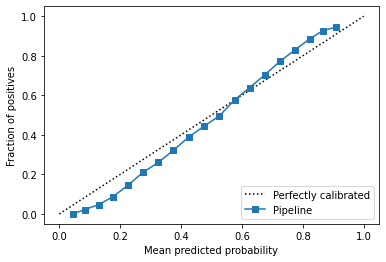

In [463]:
from sklearn.calibration import CalibrationDisplay, calibration_curve

display = CalibrationDisplay.from_estimator(
    pipe_race,
    data[X_columns][test_msk],
    data[T_columns[1]][test_msk],
    n_bins=20,
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

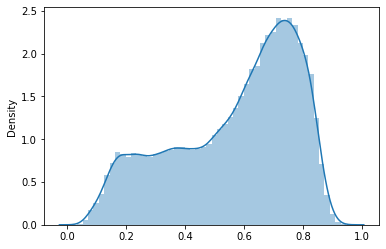

In [464]:
sns.distplot(pipe_race.predict_proba(data[X_columns][test_msk])[:,1])

In [465]:
auc_race = auc_scoring(pipe_race, data[X_columns][test_msk], data[[T_columns[0]]][test_msk])
(
    auc_scoring(pipe_race, data[X_columns][train_msk], data[[T_columns[0]]][train_msk]),
    auc_scoring(pipe_race, data[X_columns][test_msk], data[[T_columns[0]]][test_msk])
)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished

The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases 

In [466]:
race_importances = permutation_importance(pipe_race, data[X_columns][test_msk], data[[T_columns[1]]][test_msk], n_repeats = 10, n_jobs = -1, scoring = auc_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


Text(0.5, 1.0, 'Permutation feature importances for race prediction (AUC = 0.54)')

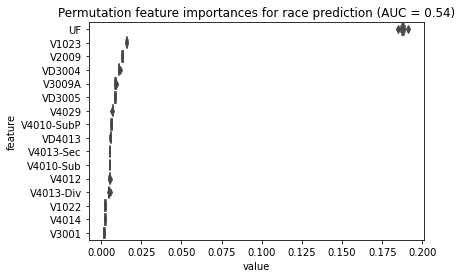

In [467]:
race_importances_df = pd.DataFrame(race_importances['importances'])
race_importances_df['feature'] = X_columns
race_importances_df = race_importances_df.melt(id_vars = ['feature'], var_name = 'iter')
race_rank = race_importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=race_importances_df,
            order = race_rank.index 
           )
plt.title(f'Permutation feature importances for race prediction (AUC = {round(auc_race,2)})')
#plt.legend()

In [468]:
#var_dict.loc[[i.replace('-Sec', '').replace('-SubP','') for i in race_rank.index]].reset_index().drop_duplicates(var_dict.index.name)

#### Wage Prediction

In [469]:
estim = RandomForestRegressor(40, criterion = 'squared_error', min_samples_leaf = 5, n_jobs = -1, verbose = 1)
#estim = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1, n_jobs = -1, verbose = 1)
pipe_wage = make_numerical_and_categorical_pipeline(categorical_columns, numerical_columns,estim)

In [470]:
pipe_wage.fit(data[X_columns][train_msk], data[y_columns][train_msk])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 34.8min finished


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['UF', 'V1022', 'V1023',
                                                   'V3001', 'V4010-SubP',
                                                   'V4010-Sub', 'V4012',
                                                   'V4013-Sec', 'V4013-Div',
                                                   'V4014', 'VD3004', 'V3009A',
                                                   'V4029', 'VD4013']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x0000020FBE5DA0D0>),
                                                  ['V2009', 'VD3005'])])),
                ('FinalEstimator',
                 Rand

In [471]:
from sklearn.calibration import CalibrationDisplay

score = r2_score(
    data[y_columns][test_msk],
    pipe_wage.predict(data[X_columns][test_msk]),
    sample_weight=None,
    multioutput='uniform_average'
)

train_score = r2_score(
    data[y_columns][train_msk],
    pipe_wage.predict(data[X_columns][train_msk]),
    sample_weight=None,
    multioutput='uniform_average'
)

train_score, score

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.4s finished

The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.

The MathtextBackendBitmap class was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.


In [472]:
train_score, score

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


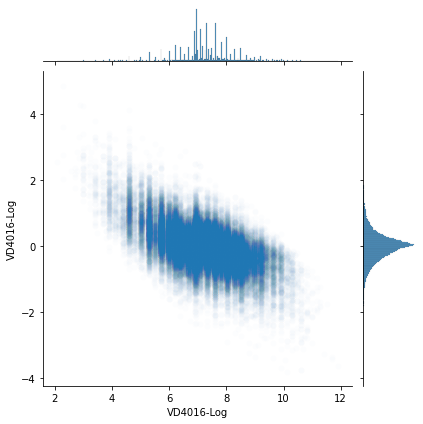

In [473]:
preds = pipe_wage.predict(data[X_columns][test_msk])

err = preds.flatten() - data[y_columns[0]][test_msk]

sns.jointplot(data[y_columns[0]][test_msk], err, joint_kws = dict(alpha = 0.01))

In [474]:
def r2_scoring(estim, X, y):
    return r2_score(
            y,
            estim.predict(X),
            sample_weight=None,
            multioutput='uniform_average'
        )

importances = permutation_importance(pipe_wage, data[X_columns][test_msk], data[y_columns][test_msk], n_repeats = 10, n_jobs = -1, scoring = r2_scoring)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished


Text(0.5, 1.0, 'Permutation feature importances for wage prediction ($R^2$ = 0.7)')

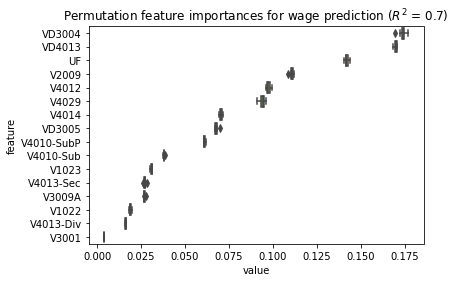

In [475]:
importances_df = pd.DataFrame(importances['importances'])
importances_df['feature'] = X_columns
importances_df = importances_df.melt(id_vars = ['feature'], var_name = 'iter')
rank = importances_df.groupby('feature')['value'].sum().sort_values(ascending = False)

#importances_df.groupby('feature').apply(lambda x: sns.boxplot(y = x['importances'], x = x['rank']))
sns.boxplot(x="value", 
            y="feature",
            data=importances_df,
            order = rank.index 
           )

plt.title(f'Permutation feature importances for wage prediction ($R^2$ = {round(score,2)})')

#plt.legend()

In [476]:
#var_dict.loc[[i.replace('-Sec', '').replace('-SubP','') for i in rank.index]].reset_index().drop_duplicates(var_dict.index.name)

É importante perceber que para inferencia causal, a performance preditiva do modelo não é tão importante assim, contanto que os modelos sejam consistentes no conjunto de treino e teste. o mais importante é que os modelos nuisance para os tratamentos consigam ortogonalizar os tratamentos e as covariantes (unconfoundedness/ignorability) e que o preditor da resposta diminua um pouco a sua variância.

# Treatment Effect with Double/Orthogonal ML

In [477]:
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.utils import check_array
class ResidualEstimator():
    
    def __init__(self, regressor = None, classifier = None):
        self.regressor = regressor
        self.classifier = classifier        
        return
    
    def fit(self, X, y_num = None, y_cat = None, **kwargs):
        
        
        if not self.regressor is None:
            numerical_estimator = MultiOutputRegressor(self.regressor)
            numerical_estimator.fit(X, y_num)
        else:
            numerical_estimator = None
            
        if not self.classifier is None:
            categorical_estimator = MultiOutputClassifier(self.classifier)                        
            categorical_estimator.fit(X, y_cat)
        else:
            categorical_estimator = None
        
        self.numerical_estimator_ = numerical_estimator
        self.categorical_estimator_ = categorical_estimator
        return self
    
    def transform(self, X, y_num = None, y_cat= None):
        if not self.numerical_estimator_ is None:
            pred_num = self.numerical_estimator_.predict(X)
            num = y_num - pred_num
        else:
            num = np.zeros((X.shape[0],0))
        
        if not self.categorical_estimator_ is None:
            pred_cat = self.categorical_estimator_.predict_proba(X)
            pred_cat = np.hstack(
                [check_array(arr) for arr in pred_cat]
            )        
            y_cat = OneHotEncoder(sparse = False, categories = self.categorical_estimator_.classes_).fit_transform(y_cat)
            cat = y_cat - pred_cat
        else:
            cat = pred_num = np.zeros((X.shape[0],0))                                            
        
        return np.hstack([num,cat])

In [478]:
data['VD4013'].value_counts(dropna = False)

3.0    312619
2.0    135232
5.0     68908
4.0     55533
1.0     20449
Name: VD4013, dtype: int64

In [513]:
categorical_columns = [
    'UF', #estado
    'V1022', #zona rural ou urbana
    'V1023', # região do estado    
    'V3001', #sabe ler ou escrever?
    'V4010-SubP', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4010-Sub', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4012', #Nesse trabalho,... era
    'V4013-Sec', #seção do código CNAE da principal atividade do trabalho
    'V4013-Div', #Divisão do código CNAE da principal atividade do trabalho
    'V4014', #esfera do trabalho (Federal estadual ou municipal)
    'VD3004', #nível de instrução mais elevado alcançado
    'V3009A', #curso mais alto que frequentou anteriormente
    'V4029', #carteira assinada    
    #'VD4032', #Horas efetivamente trabalhadas na semana de referência no trabalho principal para pessoas de 14 anos ou mais de idade    
]


numerical_columns = [
    'V2009', #idade
    'VD3005', #anos de estudo
    'VD4013', #Faixa das horas habitualmente trabalhadas
]

treatment_columns = [
    'V2007-Bin', #sexo
    'V2010-Bin', #cor ou raça binária (branco ou amarelo/ preto pardo ou indigena)
]

target_columns = [
    'VD4016-Log', #Rendimento mensal habitual do trabalho principal para pessoas de 14 anos ou mais de idade (apenas para pessoas que receberam em dinheiro, produtos ou mercadorias no trabalho principal)
]

X_columns = categorical_columns + numerical_columns
T_columns = treatment_columns
y_columns = target_columns


## First stage $X \sim{} T$

as there are only 4 possibilities in the X variables, and terminal nodes is $2^n$, where n = depth, we'll use max depth = 2

In [480]:
clf_cart = ExtraTreesClassifier(10, max_depth = 2, max_features = 4, ) #like a bootstrapped groupby 
reg_cart = ExtraTreesRegressor(10, max_depth = 2, max_features = 4,)

cat_estimator = make_numerical_and_categorical_pipeline(
    categorical_columns = treatment_columns,
    numerical_columns=[],
    final_estimator= clf_cart
)

num_estimator = make_numerical_and_categorical_pipeline(
    categorical_columns = treatment_columns,
    numerical_columns=[],
    final_estimator= reg_cart
)

stage1 = ResidualEstimator(
    num_estimator,
    cat_estimator,
)

In [481]:
stage1.fit(X = data[T_columns][train_msk], y_num = data[numerical_columns][train_msk], y_cat = data[categorical_columns][train_msk].astype(str))

## Second stage $Y \sim (X - (X \sim T))$  

or $Y \sim Residuals(X \sim T)$

In [482]:
reg_stage_2 = RandomForestRegressor(40, min_samples_leaf = 5, n_jobs = 3)
stage2 = ResidualEstimator(regressor = reg_stage_2)

In [483]:
X_T_res = stage1.transform(
    data[T_columns][train_msk],
    y_num = data[numerical_columns][train_msk],
    y_cat = data[categorical_columns][train_msk].astype(str)
) #use train data since stage 1 contains only 4 degrees of freedom and thus is unlinkely to overfit
#also, random forests with bootstrapped out of bag samples emulates cross validaiton

In [484]:
X_T_res_test = stage1.transform(
    data[T_columns][test_msk],
    y_num = data[numerical_columns][test_msk],
    y_cat = data[categorical_columns][test_msk].astype(str)
) #use train data since stage 1 contains only 4 degrees of freedom and thus is unlinkely to overfit
#also, random forests with bootstrapped out of bag samples emulates cross validaiton

In [485]:
y = data[y_columns][train_msk]
y_test = data[y_columns][test_msk]

In [486]:
stage2.fit(X_T_res, y_num = y)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

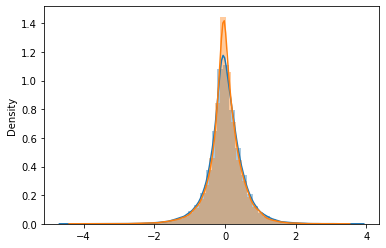

In [487]:
msk = data['V2007-Bin'][test_msk].str.contains('lin')
Y_X_T_res_test = stage2.transform(X_T_res_test, y_num = y_test, y_cat = None)
sns.distplot(Y_X_T_res_test[msk])
sns.distplot(Y_X_T_res_test[~msk])

## Final stage $Y - (Y \sim (X - (X \sim T))) \sim T$ 
or
$Residuals(Y \sim Residuals(X \sim T)) \sim T $

In [488]:
reg_stage_final = RandomForestRegressor(10, min_samples_leaf = 10, n_jobs = -1, max_depth = 2)

stage_final = make_numerical_and_categorical_pipeline(
    categorical_columns = T_columns,
    numerical_columns = [],
    final_estimator= reg_stage_final
)

In [489]:
stage_final.fit(data[T_columns][test_msk], Y_X_T_res_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Pipeline(steps=[('PreprocessingPipeline',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  RobustEncoder(),
                                                  ['V2007-Bin', 'V2010-Bin']),
                                                 ('NumericalPassthrough',
                                                  FunctionTransformer(func=<function make_numerical_and_categorical_pipeline.<locals>.<lambda> at 0x0000021063AE9700>),
                                                  [])])),
                ('FinalEstimator',
                 RandomForestRegressor(max_depth=2, min_samples_leaf=10,
                                       n_estimators=10, n_jobs=-1))])

In [490]:
def predict_all_stages(stage1, stage2, stage_final, X_num, X_cat, T, y):
    out1 = stage1.transform(T, y_num = X_num, y_cat = X_cat)
    out2 = stage2.transform(out1, y_num = y)
    out_final = stage_final.predict(T)
    return out_final
    

In [491]:

factual = predict_all_stages(
    stage1,
    stage2,
    stage_final,    
    X_num = data[numerical_columns][test_msk],
    X_cat = data[categorical_columns][test_msk].astype(str),
    T = data[T_columns][test_msk],
    y = data[y_columns][test_msk]  
)

In [492]:
data[T_columns]

,V2007-Bin,V2010-Bin
0,Feminino,"Preta, Parda ou Indígena"
1,Feminino,"Preta, Parda ou Indígena"
2,Masculino,Branca ou Amarela
3,Feminino,"Preta, Parda ou Indígena"
4,Masculino,Branca ou Amarela
...,...,...
592736,Feminino,"Preta, Parda ou Indígena"
592737,Masculino,Branca ou Amarela
592738,Feminino,"Preta, Parda ou Indígena"
592739,Masculino,"Preta, Parda ou Indígena"


In [493]:
T_race_cf = data[T_columns][test_msk].replace('Preta, Parda ou Indígena', 'Branca ou Amarela')

counter_factual_race = predict_all_stages(
    stage1,
    stage2,
    stage_final,    
    X_num = data[numerical_columns][test_msk],
    X_cat = data[categorical_columns][test_msk].astype(str),
    T = T_race_cf,
    y = data[y_columns][test_msk]  
)

In [494]:
d = data[test_msk]
d['factual_res'] = factual


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [495]:
d['cf_race'] = counter_factual_race


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [496]:
d['race_effect'] = d['factual_res'] - d['cf_race']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [497]:
np.expm1(d.groupby(T_columns)['race_effect'].mean())

V2007-Bin  V2010-Bin               
Feminino   Branca ou Amarela           0.000000
           Preta, Parda ou Indígena   -0.008040
Masculino  Branca ou Amarela           0.000000
           Preta, Parda ou Indígena   -0.003924
Name: race_effect, dtype: float64

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='race_effect', ylabel='Density'>

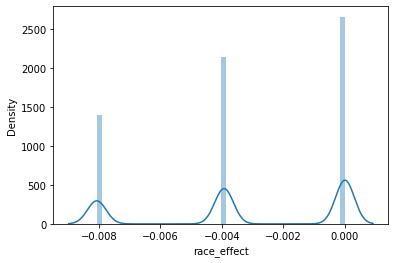

In [498]:
sns.distplot(d['race_effect'])

In [499]:
T_sex_cf = data[T_columns][test_msk].replace('Feminino', 'Masculino')

counter_factual_sex = predict_all_stages(
    stage1,
    stage2,
    stage_final,    
    X_num = data[numerical_columns][test_msk],
    X_cat = data[categorical_columns][test_msk].astype(str),
    T = T_sex_cf,
    y = data[y_columns][test_msk]  
)

In [500]:
d['cf_sex'] = counter_factual_sex


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [501]:
d['sex_effect'] = d['factual_res'] - d['cf_sex']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [502]:
np.expm1(d.groupby(T_columns)['sex_effect'].mean())

V2007-Bin  V2010-Bin               
Feminino   Branca ou Amarela          -1.380575e-03
           Preta, Parda ou Indígena   -5.507409e-03
Masculino  Branca ou Amarela           4.336809e-19
           Preta, Parda ou Indígena   -1.084202e-19
Name: sex_effect, dtype: float64

# Direct treatment effect with TLearner

In [48]:
categorical_columns = [
    'UF', #estado
    'V1022', #zona rural ou urbana
    'V1023', # região do estado    
    'V3001', #sabe ler ou escrever?
    'V4010-SubP', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4010-Sub', #subgrupo principal da ocupação de acordo com Estrutura_Ocupacao_COD
    'V4012', #Nesse trabalho,... era
    'V4013-Sec', #seção do código CNAE da principal atividade do trabalho
    'V4013-Div', #Divisão do código CNAE da principal atividade do trabalho
    'V4014', #esfera do trabalho (Federal estadual ou municipal)
    'VD3004', #nível de instrução mais elevado alcançado
    'V3009A', #curso mais alto que frequentou anteriormente
    'V4029', #carteira assinada    
    #'VD4032', #Horas efetivamente trabalhadas na semana de referência no trabalho principal para pessoas de 14 anos ou mais de idade    
]


numerical_columns = [
    'V2009', #idade
    'VD3005', #anos de estudo
    'VD4013', #Faixa das horas habitualmente trabalhadas
]

treatment_columns = [
    'V2007-Bin', #sexo
    'V2010-Bin', #cor ou raça binária (branco ou amarelo/ preto pardo ou indigena)
]

target_columns = [
    'VD4016-Log', #Rendimento mensal habitual do trabalho principal para pessoas de 14 anos ou mais de idade (apenas para pessoas que receberam em dinheiro, produtos ou mercadorias no trabalho principal)
]

X_columns = categorical_columns + numerical_columns
T_columns = treatment_columns
y_columns = target_columns


In [49]:
train_frac = 0.8
train_idxs = np.random.choice(range(len(data)), size = int(len(data)*train_frac), replace = False)

train_msk = np.empty((len(data),), dtype = bool)
train_msk[:] = False
train_msk[train_idxs] = True
test_msk = ~train_msk

In [50]:
from sklearn.base import clone, BaseEstimator

class TLearner(BaseEstimator):
    
    def __init__(self, effect_estimator, propensity_estimator, X_columns, T_columns, y_columns, propensity_threshold = 0.0):
        '''
        Parameters
        ----------
        
        effect_estimator: sklearn estimator
            base estimator for the counter factual effect estimation
        
        propensity_estimator: sklearn estimator
            base estimator for the propensity score estimator
        
        X_columns: list of str
             covariates columns
        
        T_columns: list of str
            treatment variable columns
        
        y_columns: list of str
            target columns
            
        propensity_threshold: float
            propensity score threshold for filtering data during fit and inference. 
            Imporatant to ensure positivity assumption.
            
        
        Returns
        -------
        
        TLearner estimator
        '''
        self.effect_estimator = effect_estimator
        self.propensity_estimator = propensity_estimator
        self.X_columns = X_columns
        self.T_columns = T_columns
        self.y_columns = y_columns        
        self.propensity_threshold = propensity_threshold
        return
            
    def fit(self, df, **kwargs):
        
        
        propensity_model = self.propensity_estimator.fit(
            df[self.X_columns],
            df[self.T_columns].apply(tuple, axis = 1).astype(str)
        )
        
        propensities = propensity_model.predict_proba(df[self.X_columns])        
        p_mask = (propensities >= self.propensity_threshold).all(axis = 1)
        
        effect_models = df[p_mask].groupby(T_columns).apply(
            lambda df: clone(self.effect_estimator).fit(
                df[self.X_columns],
                df[self.y_columns],
                **kwargs
            )
        )
                
                        
        self.p_mask_ = p_mask
        self.effect_models = effect_models
        self.propensity_model = propensity_model
        return self
        
    def counterfactuals(self, df, method = 'predict'):
        
        d = {}
        for i in self.effect_models.index:
            d[i] = getattr(self.effect_models.loc[i], method)(df[self.X_columns]).flatten()
                
        d = pd.DataFrame(d)
        index = d.index
        columns = d.columns
        
        propensities = self.propensity_score(df)
        d = np.where(propensities >= self.propensity_threshold, d, np.nan)
                        
        return pd.DataFrame(d, index = index, columns = columns)
    
    def propensity_score(self, df):
        scores = self.propensity_model.predict_proba(df[self.X_columns])        
        return pd.DataFrame(
            scores,
            columns = pd.MultiIndex.from_tuples([eval(i) for i in self.propensity_model.classes_])
        )
        
    def predict(self, df):
        
        def _predict(x):
            grp = list(x.groupby(self.T_columns).groups)[0]
            results = self.effect_models.loc[grp].predict(x[self.X_columns])
            results = pd.DataFrame(results)
            results['_index'] = x.index
            return results
        
        results = df.reset_index().groupby(self.T_columns).apply(_predict)
        results = results.sort_values(by = '_index').iloc[:,0].values
                        
        return results

        
from scipy.stats import dirichlet
def baesyan_bootstrap(samples, n_bootstraped_samples):
    '''
    a function to calculate bootstraped mean of distribution using dirichlet sampling
    '''
    samples = np.array(samples)
    samples = samples[~np.isnan(samples)]
    likelihoods = dirichlet([1]*len(samples)).rvs(n_bootstraped_samples)
    return (likelihoods*samples.reshape(1,-1)).sum(axis = 1)

def remove_duplicate_columns(df):
    return df.loc[:,~df.columns.duplicated()]


In [51]:
data = remove_duplicate_columns(data)

In [375]:
from sklearn.ensemble import ExtraTreesRegressor
regressor = RandomForestRegressor(20, min_samples_leaf = 20, n_jobs = -1, max_samples = 0.5)
#regressor = ExtraTreesRegressor(100, min_samples_leaf = 20, n_jobs = -1, max_samples = 0.5)
#classifier = RandomForestClassifier(20, min_samples_leaf = 20, n_jobs = -1, max_samples = 0.5)
#regressor = LinearRegression(n_jobs = -1)
classifier = LogisticRegression(n_jobs = -1)

regressor_pipeline = make_numerical_and_categorical_pipeline(    
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns,
    final_estimator = regressor
)

classifier_pipeline = make_numerical_and_categorical_pipeline(    
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns,
    final_estimator = classifier
)

In [376]:
estim = TLearner(
    regressor_pipeline,
    classifier_pipeline,
    X_columns,
    T_columns,
    y_columns,
    propensity_threshold = 0.05
)

In [377]:
estim.fit(data[train_msk])

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ra

TLearner(T_columns=['V2007-Bin', 'V2010-Bin'],
         X_columns=['UF', 'V1022', 'V1023', 'V3001', 'V4010-SubP', 'V4010-Sub',
                    'V4012', 'V4013-Sec', 'V4013-Div', 'V4014', 'VD3004',
                    'V3009A', 'V4029', 'V2009', 'VD3005', 'VD4013'],
         effect_estimator=Pipeline(steps=[('PreprocessingPipeline',
                                           ColumnTransformer(transformers=[('OneHotEncoder',
                                                                            RobustEncoder(),
                                                                            ['UF',
                                                                             'V1022',
                                                                             'V1023',
                                                                             'V...
                                               ColumnTransformer(transformers=[('OneHotEncoder',
                                         

In [378]:
r2_score(data[test_msk][y_columns].values.flatten(), estim.predict(data[test_msk])), r2_score(data[train_msk][y_columns].values.flatten(), estim.predict(data[train_msk]))

(0.5873494047571377, 0.5995774843644592)

# Results and Analysis

In [379]:
results = estim.counterfactuals(data[test_msk])
propensity_scores = estim.propensity_score(data[test_msk])
predictions = estim.predict(data[test_msk])

In [380]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, normalize

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA

import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd

def calibration_plots(y_true, y_proba, classes, n_bins = 20):

    if len(y_true.shape) == 1:
        y_true = y_true.reshape(-1,1)

    if len(y_true.flatten()) == y_true.shape[0]:
        ohe = OneHotEncoder(categories = classes)
        one_hot_targets = ohe.fit_transform(y_true).A
    else:
        one_hot_targets = y_true

    fig = go.Figure()
    for label_id in range(len(classes[0])):
        true = one_hot_targets[:,label_id].flatten()
        proba_true = y_proba[:,label_id].flatten()
        prob_true, prob_pred = calibration_curve(true, proba_true, normalize=False, n_bins=n_bins, strategy='uniform')
        trace = go.Scatter(x=prob_pred, y=prob_true,
                        mode = 'lines+markers',
                        name = classes[0][label_id])

        fig.add_trace(trace)


    fig.update_xaxes(title="prob_pred")
    fig.update_yaxes(title="prob_true")
    # add y = x trace
    fig.add_trace(
        go.Scatter(x=[0,1], y=[0,1],
                    mode = 'lines+markers',
                    name = 'y = x',
                    line = dict(dash = 'dash')
                  )
    )


    fig.update_layout(title = 'Calibration Curves')
    return fig

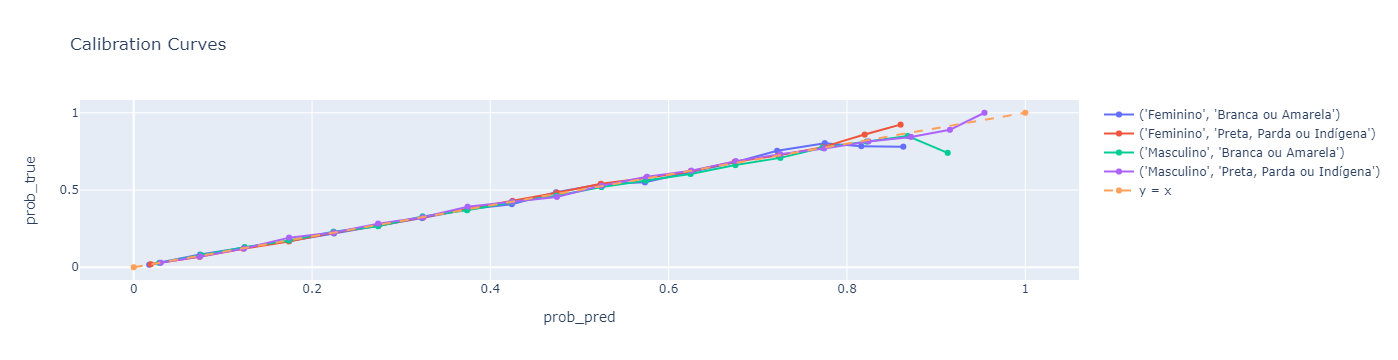

<Figure size 432x288 with 0 Axes>

In [381]:
plt.subplots_adjust(0,-1)
calibration_plots(
    data[test_msk][T_columns].apply(tuple, axis = 1).astype(str).values,
    propensity_scores.values,
    [estim.propensity_estimator.classes_],
    n_bins = 20
)


In [382]:
control_predictions = estim.effect_models.iloc[-2].predict(data[test_msk])

In [383]:
deltas = np.exp(results - results[[results.columns[2]]].values)

In [384]:
deltas['log_wage'] = data[test_msk][y_columns].values

In [385]:
val_data = data[test_msk]
val_data['predictions'] = predictions

C:\Users\USERAM~1\AppData\Local\Temp/ipykernel_20180/267237958.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [386]:
bins = np.linspace(0, 12, 12)
digitized_wage = np.digitize(data[test_msk][y_columns].values, bins)
#digitized_wage = [data[test_msk][y_columns].values[digitized == i].mean() for i in range(1, len(bins))]

In [387]:
msk = (propensity_scores > 0.05).all(axis = 1).values
#msk = (data[test_msk]['VD4016-Log'] > 8).values

In [388]:
msk.mean()

0.42871723928502137

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter 

Text(0.5, 1.0, 'Log-Wage distribution for each group')

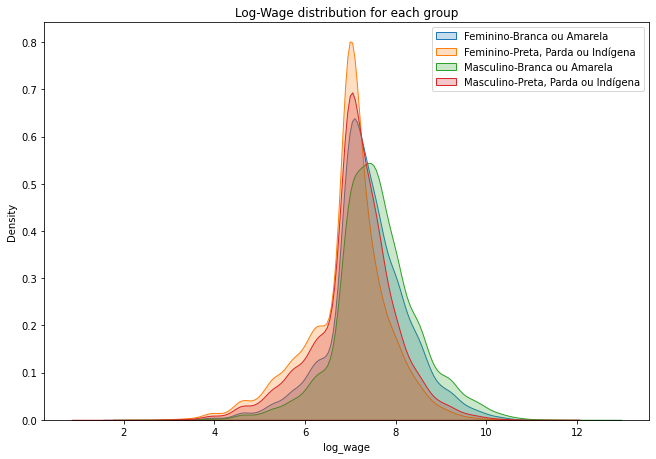

In [389]:
for gro, df in data.sample(500000).rename(columns = {y_columns[0]: 'log_wage'}).groupby(['V2007-Bin', 'V2010-Bin'])['log_wage']:
    sns.kdeplot(df, label = '-'.join(gro),bw = 0.2, shade = True, cumulative = False)
plt.legend()
plt.subplots_adjust(-.5,-.5)
plt.title('Log-Wage distribution for each group')

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter 

Text(0.5, 1.0, 'Counterfactul Log-Wage distribution for each group')

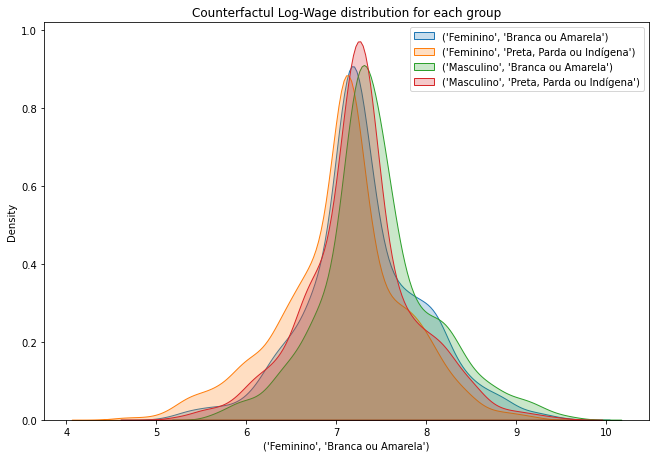

In [390]:
for col in results:
    sns.kdeplot(results[col], label = col,bw = 0.2, shade = True)
plt.legend()
plt.subplots_adjust(-.5,-.5)
plt.title('Counterfactul Log-Wage distribution for each group')

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.



Text(0.5, 1.0, 'Log-Wage distribution for each group')

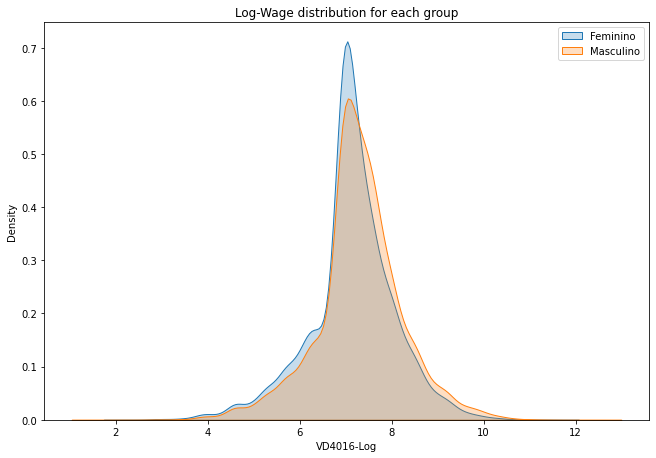

In [391]:
for gro, df in data.sample(100000).groupby(['V2007-Bin'])[y_columns[0]]:
    sns.kdeplot(df, label = gro,bw = 0.2, shade = True)
plt.legend()
plt.subplots_adjust(-.5,-.5)
plt.title('Log-Wage distribution for each group')

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.



Text(0.5, 1.0, 'Log-Wage distribution for each group')

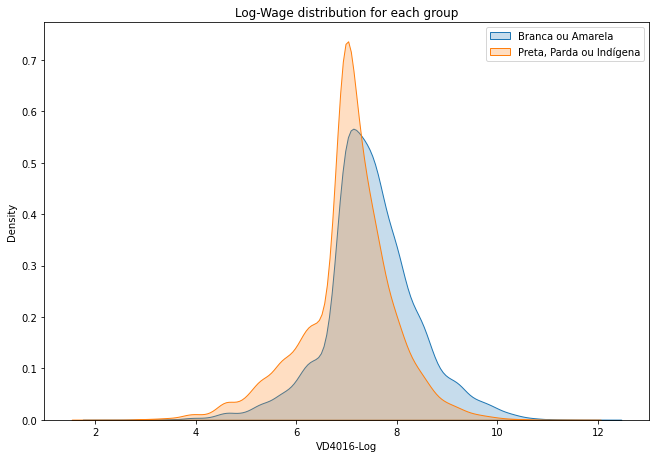

In [392]:
for gro, df in data.sample(100000).groupby(['V2010-Bin'])[y_columns[0]]:
    sns.kdeplot(df, label = gro, bw = 0.2, shade = True)
plt.legend()
plt.subplots_adjust(-.5,-.5)
plt.title('Log-Wage distribution for each group')

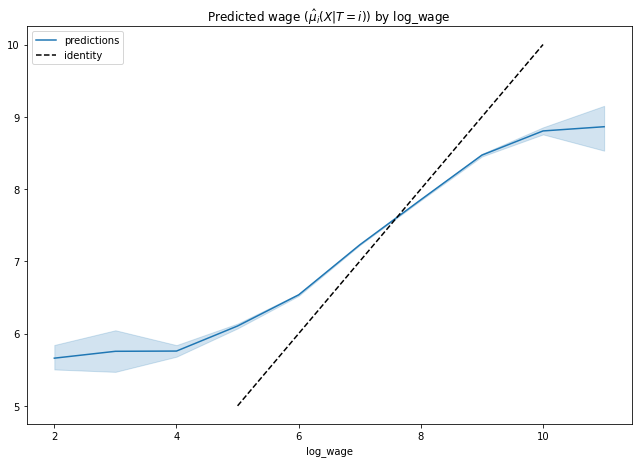

In [393]:
d = val_data[['predictions']].assign(log_wage = digitized_wage).set_index('log_wage')

sns.lineplot(
    data=d[msk],
)
plt.title('Predicted wage ($\hat{\mu}_i(X | T  = i)$) by log_wage')
plt.plot([5,10],[5,10], ls = '--', color = 'black', label = 'identity')
plt.subplots_adjust(-.5, -.5)
plt.legend()

In [394]:
45.34*16

725.44

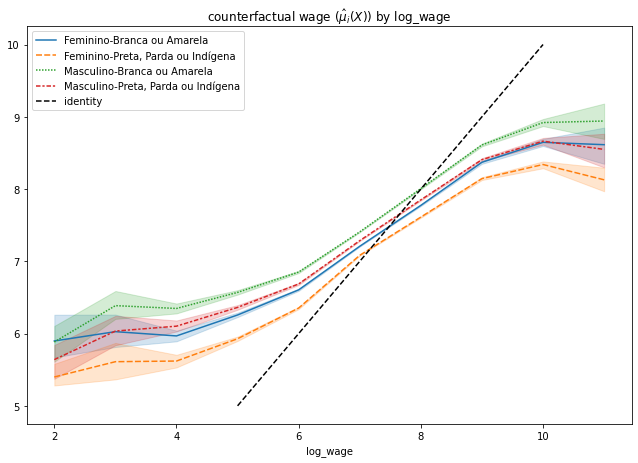

In [395]:
d = results.assign(log_wage = digitized_wage).set_index('log_wage')
d.columns = ['-'.join(i) for i in d.columns]

sns.lineplot(
    data=d[msk],
)
plt.title('counterfactual wage ($\hat{\mu}_i(X)$) by log_wage')
plt.plot([5,10],[5,10], ls = '--', color = 'black', label = 'identity')
plt.subplots_adjust(-.5, -.5)
plt.legend()

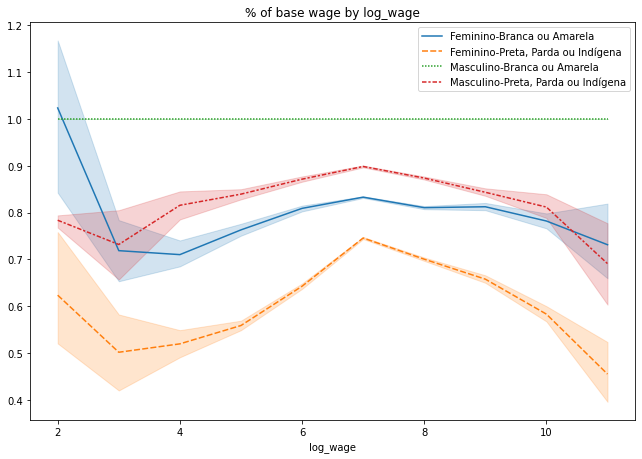

In [396]:
d = deltas.assign(log_wage = digitized_wage).set_index('log_wage')
d.columns = ['-'.join(i) for i in d.columns]

sns.lineplot(
    data=d[msk],
)
plt.title('% of base wage by log_wage')
plt.subplots_adjust(-.5, -.5)

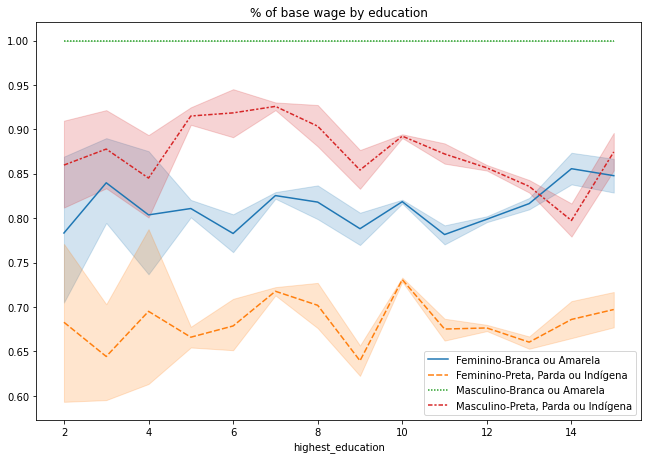

In [397]:
d = deltas.assign(highest_education = data[test_msk]['V3009A'].values).set_index('highest_education').drop(columns = ['log_wage'])
d.columns = ['-'.join(i) for i in d.columns]

sns.lineplot(
    data=d[msk],
)
plt.title('% of base wage by education')
plt.subplots_adjust(-.5, -.5)

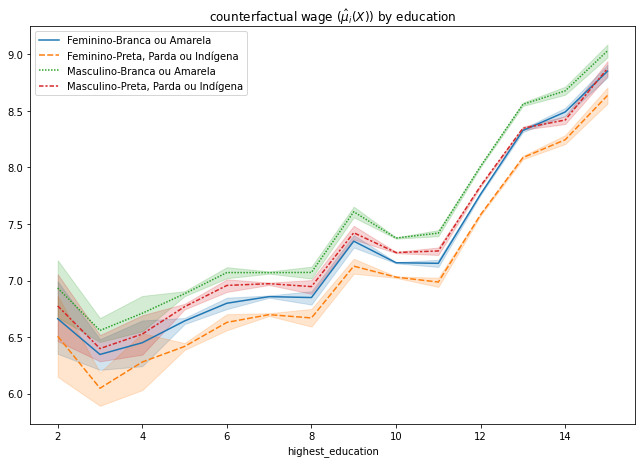

In [398]:
d = results.assign(highest_education = data[test_msk]['V3009A'].values).set_index('highest_education')
d.columns = ['-'.join(i) for i in d.columns]

sns.lineplot(
    data=d[msk],
)
plt.title('counterfactual wage ($\hat{\mu}_i(X)$) by education')
plt.subplots_adjust(-.5, -.5)

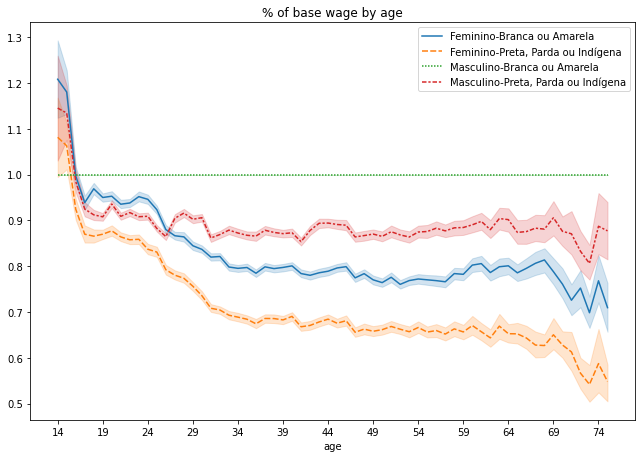

In [399]:
binned_age = data[test_msk]['V2009'].values
d = deltas.assign(
    age = np.where(data[test_msk]['V2009'].values > 75, np.nan, data[test_msk]['V2009'].values)
).set_index('age').drop(columns = ['log_wage'], errors = 'ignore')
d.columns = ['-'.join(i) for i in d.columns]

sns.lineplot(
    data=d[msk],
)
plt.xticks(np.arange(d.index.min(), d.index.max(), 5))
plt.title('% of base wage by age')
plt.subplots_adjust(-.5, -.5)

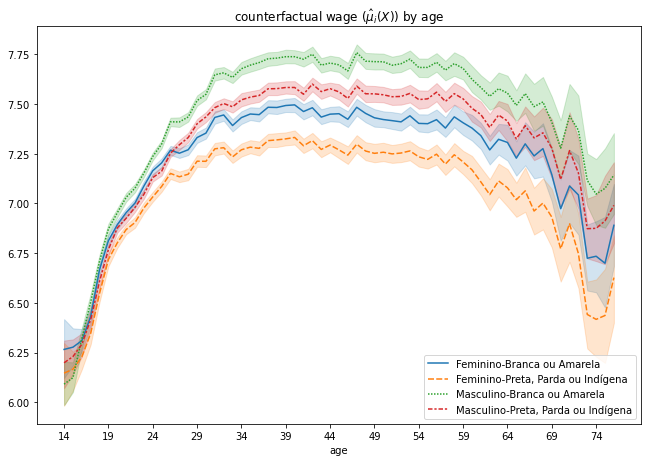

In [400]:
binned_age = data[test_msk]['V2009'].values

d = results.assign(
    age = np.where(data[test_msk]['V2009'].values > 76, np.nan, data[test_msk]['V2009'].values)
).set_index('age').drop(columns = ['log_wage'], errors = 'ignore')

d.columns = ['-'.join(i) for i in d.columns]

sns.lineplot(
    data=d[msk],
)
plt.xticks(np.arange(d.index.min(), d.index.max(), 5))
plt.title('counterfactual wage ($\hat{\mu}_i(X)$) by age')
plt.subplots_adjust(-.5, -.5)

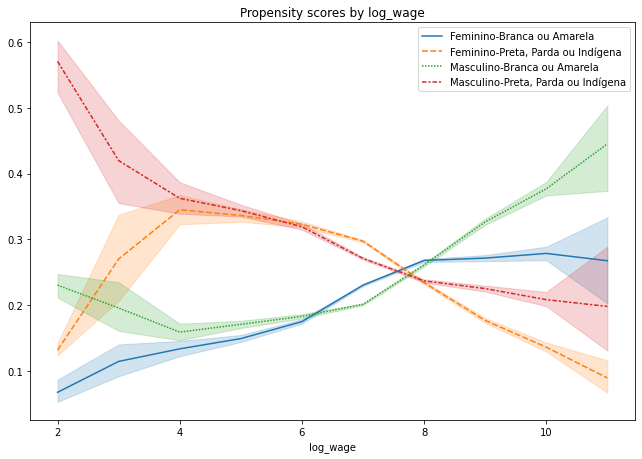

In [401]:
d = propensity_scores.assign(log_wage = digitized_wage).set_index('log_wage')
d.columns = ['-'.join(i) for i in d.columns]

sns.lineplot(
    data=d[msk],
)
plt.title('Propensity scores by log_wage')
plt.subplots_adjust(-.5, -.5)

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot

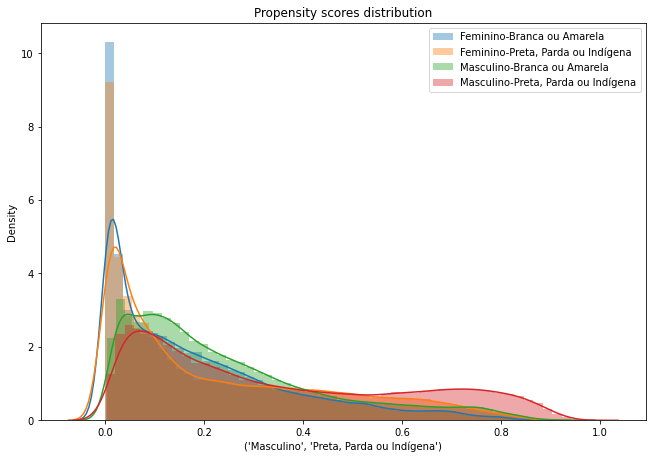

In [402]:
propensity_scores.apply(lambda x: sns.distplot(x, label = '-'.join(x.name)))
plt.legend()
plt.title('Propensity scores distribution')

plt.subplots_adjust(-.5,-.5)

In [460]:
biased_difference_in_wage = np.exp(
    data[test_msk][msk].groupby(T_columns)[y_columns].mean()
    -
    data[test_msk][msk].groupby(T_columns)[y_columns].mean().loc[('Masculino', 'Branca ou Amarela')]
)

In [461]:
unbiased_difference_in_wage = pd.DataFrame(deltas[msk].mean())
unbiased_difference_in_wage.columns = biased_difference_in_wage.columns

In [462]:
bias = biased_difference_in_wage - unbiased_difference_in_wage.loc[biased_difference_in_wage.index]

bias.columns = bias.columns + ' naive estimation bias'

In [463]:
unbiased_difference_in_wage.columns = biased_difference_in_wage.columns + ' unbiased'
unbiased_difference_in_wage = unbiased_difference_in_wage.drop('log_wage', errors = 'ignore')
unbiased_difference_in_wage.index = biased_difference_in_wage.index

We can see that the differences in wage are less than the biased one, but still is very significant, if we consider that we are comparing individuals with same attributes, except from race and gender

In [464]:
d = pd.concat([biased_difference_in_wage, unbiased_difference_in_wage, bias], axis = 1).rename(
    columns = {'VD4016-Log unbiased': '% wage - unbiased', 'VD4016-Log naive estimation bias': '% bias', 'VD4016-Log': '% wage'}
).round(3)

d.index.names = ['Gender','Race']
d

% wage  % wage - unbiased  % bias
Gender    Race                                                       
Feminino  Branca ou Amarela          0.815              0.822  -0.006
          Preta, Parda ou Indígena   0.568              0.713  -0.146
Masculino Branca ou Amarela          1.000              1.000   0.000
          Preta, Parda ou Indígena   0.720              0.884  -0.165

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot

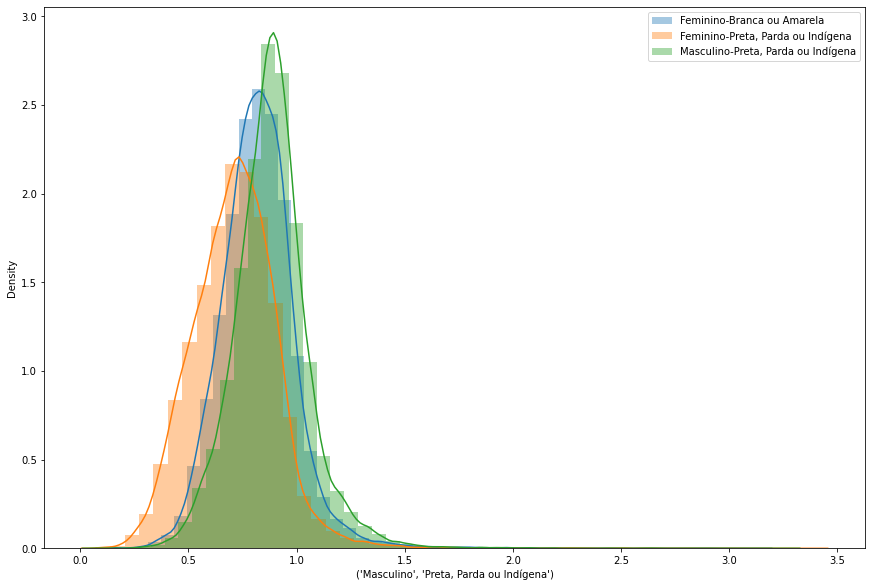

In [408]:
deltas[msk].iloc[:,[0,1,3]].apply(lambda x: sns.distplot(x, label = '-'.join(x.name)))
plt.legend()
plt.subplots_adjust(-1,-1)

## Analysis

In [409]:
import geopandas as gpd

In [410]:
brazil_map = gpd.read_file('../data/bcim_2016_21_11_2018.gpkg', layer = 'lim_unidade_federacao_a')

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\pandas\core\frame.py:9190: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



Text(0.5, 1.0, 'Estimated %-base wage per state of federation')

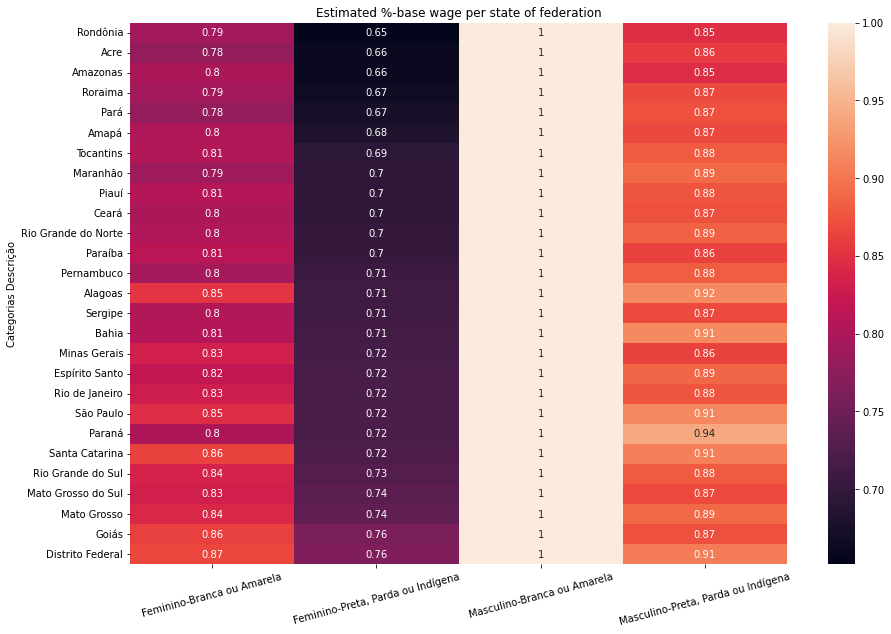

In [411]:
d = (
    pd.DataFrame(deltas[msk]).drop(columns= ['log_wage']).groupby(data[test_msk].reset_index()['UF'][msk]).mean()
    .merge(
        var_dict.loc['UF'][['Categorias Tipo ', 'Categorias Descrição']].set_index('Categorias Tipo '),
        left_index = True, right_index = True,
        how = 'left'
    )
    .set_index('Categorias Descrição')
)

sns.heatmap(
    d.sort_values(by = d.columns[1]),
    yticklabels = d.index,
    xticklabels = ['-'.join(i) for i in d.columns],
    annot = True
)

plt.subplots_adjust(-1,-1)
plt.xticks(rotation=15)
plt.title('Estimated %-base wage per state of federation')

In [412]:
brazil_map = brazil_map.merge(d, right_index = True, left_on = 'nome', how = 'left')

In [413]:
brazil_map.columns[-3]

('Feminino', 'Preta, Parda ou Indígena')

Text(0.5, 1.0, "wage gap for ('Feminino', 'Branca ou Amarela')")

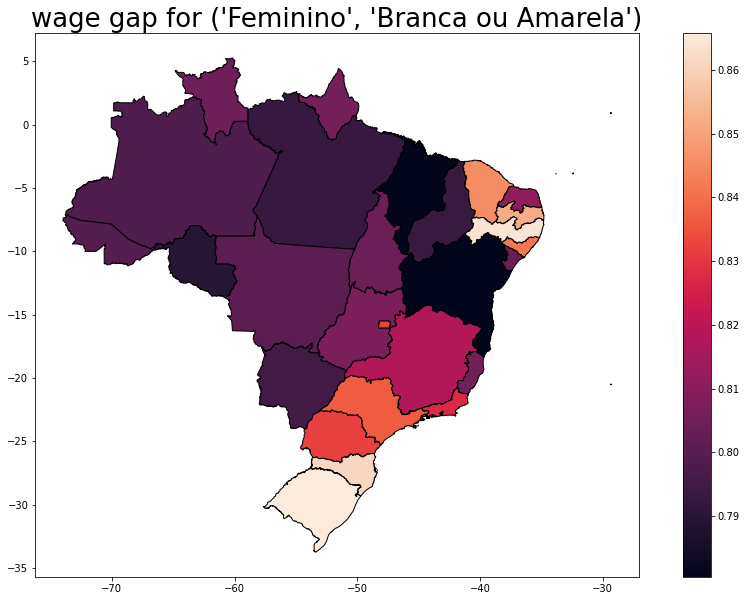

In [430]:
brazil_map.plot(
    column = brazil_map.columns[-4],
    cmap = 'rocket',
    legend = True,
    figsize = (16,10),
    edgecolor = 'black'
)
plt.title(f'wage gap for {brazil_map.columns[-4]}', fontsize = 26)

Text(0.5, 1.0, "wage gap for ('Masculino', 'Preta, Parda ou Indígena')")

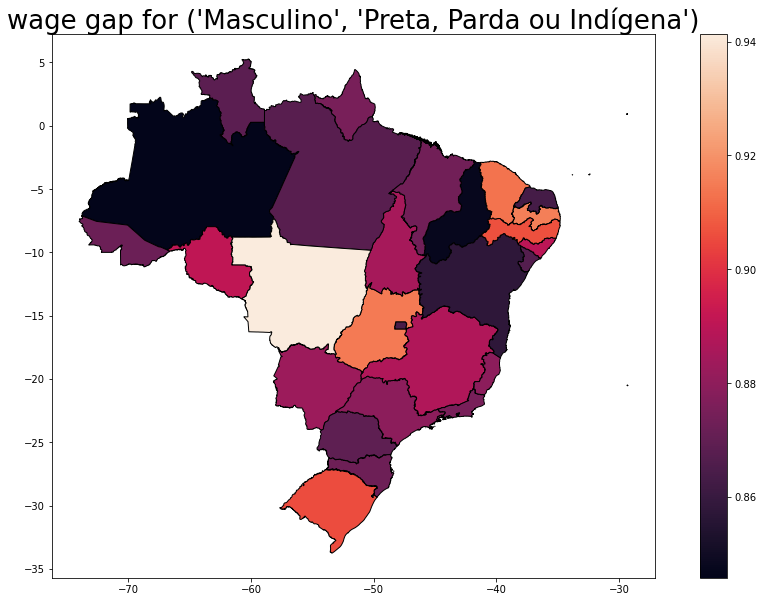

In [431]:
brazil_map.plot(
    column = brazil_map.columns[-1],
    cmap = 'rocket',
    legend = True,
    figsize = (16,10),
    edgecolor = 'black'
)
plt.title(f'wage gap for {brazil_map.columns[-1]}', fontsize = 26)

Text(0.5, 1.0, "wage gap for ('Feminino', 'Preta, Parda ou Indígena')")

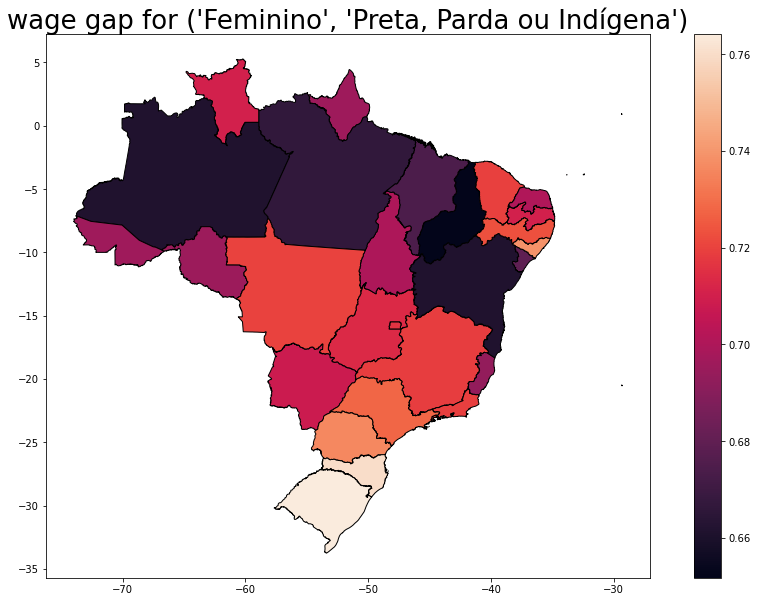

In [432]:
brazil_map.plot(
    column = brazil_map.columns[-3],
    cmap = 'rocket',
    legend = True,
    figsize = (16,10),
    edgecolor = 'black'
)
plt.title(f'wage gap for {brazil_map.columns[-3]}', fontsize = 26)

In [417]:
idh_data = pd.read_csv('../data/data_idh_atlas_brasil.csv', sep = ';')

idh_metric = 'Posição IDHM Renda'
d = (
    pd.DataFrame(deltas).drop(columns= ['log_wage']).assign(UF = data[test_msk]['UF'])[msk].set_index('UF')
    .merge(
        var_dict.loc['UF'][['Categorias Tipo ', 'Categorias Descrição']].set_index('Categorias Tipo '),
        left_index = True, right_index = True,
        how = 'left'
    )
    .merge(
        idh_data[['Territorialidade',idh_metric]], right_on = 'Territorialidade', left_on = 'Categorias Descrição'
    )
    .set_index('Categorias Descrição')
)

C:\Users\User Ambev\Desktop\Mestrado\MO444\MO444env\lib\site-packages\pandas\core\frame.py:9190: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



In [418]:
d = d.set_index(idh_metric).drop(columns = ['Territorialidade'])

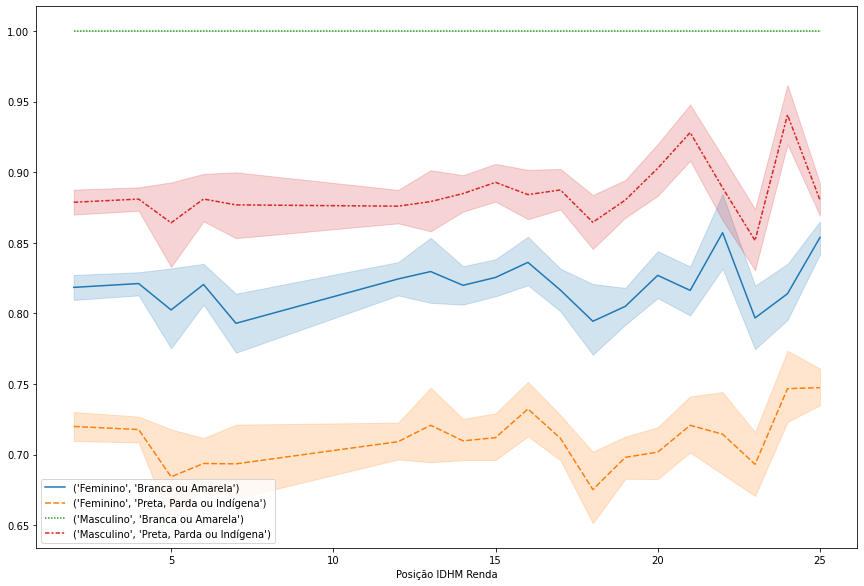

In [419]:
sns.lineplot(
    data = d
)
plt.subplots_adjust(-1,-1)

Text(0.5, 1.0, 'Estimated %-base wage per job role')

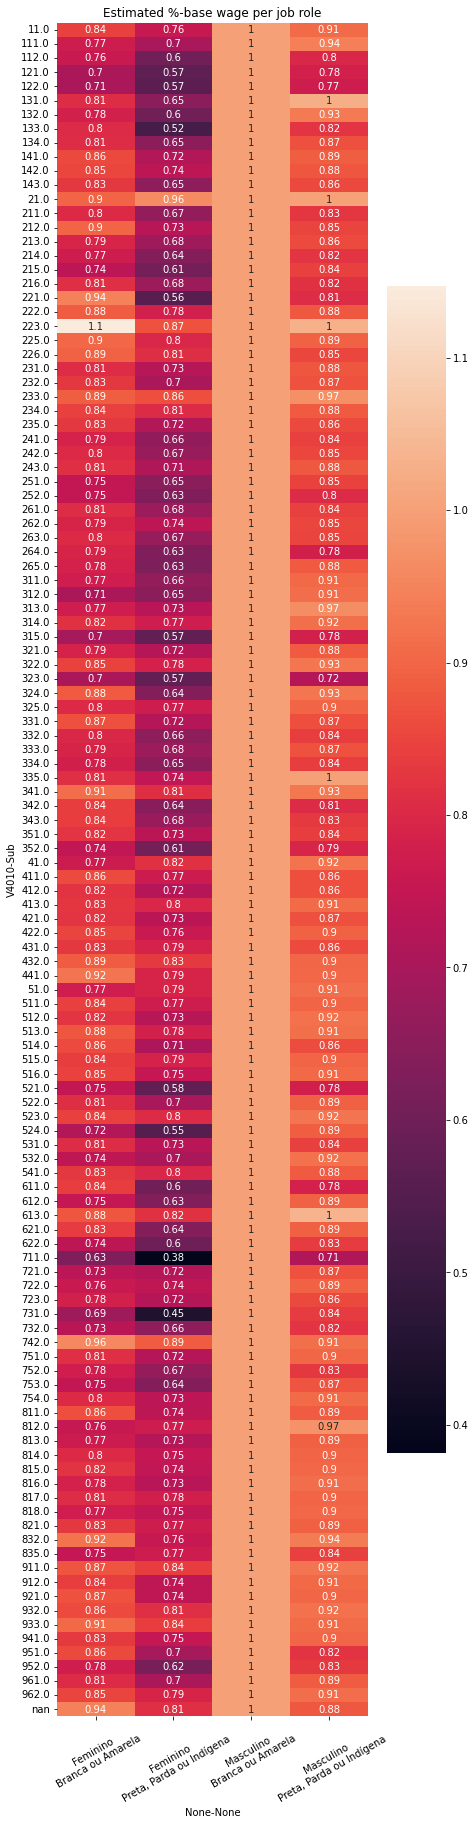

In [420]:
d = pd.DataFrame(deltas[msk]).drop(columns= ['log_wage']).groupby(data[test_msk].reset_index()['V4010-Sub'][msk]).median()
    
sns.heatmap(
    d,
    yticklabels = d.index,
    xticklabels = ['\n'.join(i) for i in d.columns],
    annot = True
)

plt.subplots_adjust(0,-5)
plt.xticks(rotation=30)
plt.title('Estimated %-base wage per job role')

In [421]:
pd.read_excel(r'..\data\Estrutura_Ocupacao_COD.xls').fillna(method = 'ffill').query('`Subgrupo` == 711')

,Grande Grupo,Subgrupo principal,Subgrupo,Grupo de base,Denominação
406,7.0,71.0,711.0,6225.0,Trabalhadores da construção civil em obras est...
407,7.0,71.0,711.0,7111.0,Construtores de casas
408,7.0,71.0,711.0,7112.0,Pedreiros
409,7.0,71.0,711.0,7113.0,"Canteiros, cortadores e gravadores de pedras"
410,7.0,71.0,711.0,7114.0,Trabalhadores em cimento e concreto armado
411,7.0,71.0,711.0,7115.0,Carpinteiros
412,7.0,71.0,711.0,7119.0,Outros trabalhadores qualificados e operários ...


Text(0.5, 1.0, 'Estimated %-base wage per Job Sector')

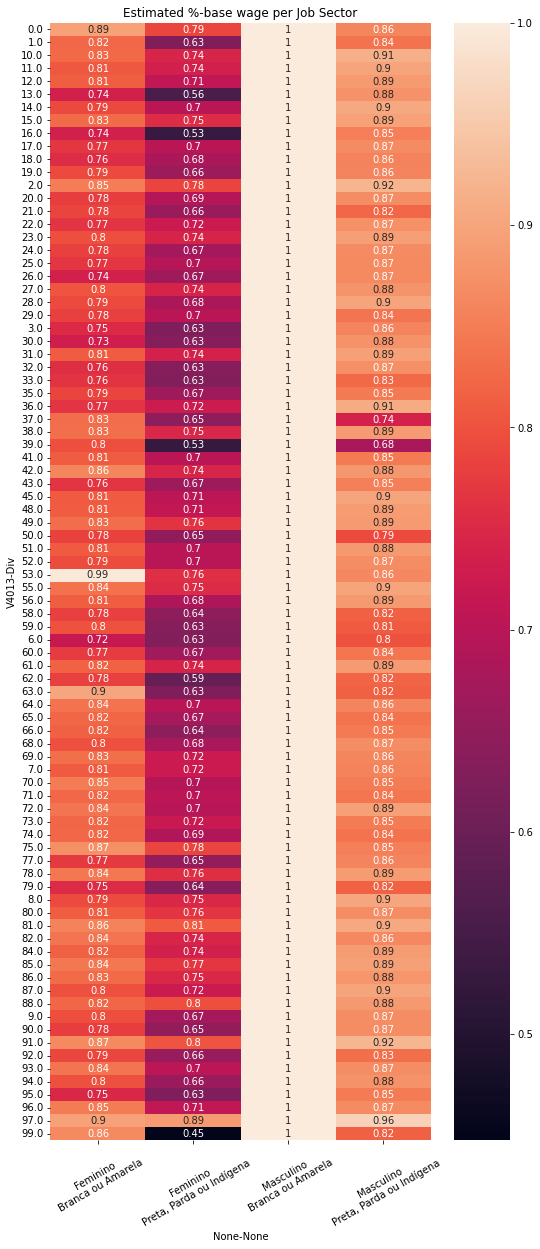

In [422]:
d = pd.DataFrame(deltas[msk]).drop(columns= ['log_wage']).groupby(data[test_msk].reset_index()['V4013-Div'][msk].astype(str)).median()
    
sns.heatmap(
    d,
    yticklabels = d.index,
    xticklabels = ['\n'.join(i) for i in d.columns],
    annot = True
)

plt.subplots_adjust(-.2,-3)
plt.xticks(rotation=30)
plt.title('Estimated %-base wage per Job Sector')

In [423]:
load_cnae_codes().query('`V4013-Div` == 39')

,V4013,V4013-Div,V4013-Sec,V4013-Name
111,39000.0,39.0,E,[Descontaminação e outros serviços de gestão d...


In [424]:
var_dict[var_dict['Quesito Descrição'].str.contains('carteira')]

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
V4029,183.0,1.0,29,"Nesse trabalho, ... tinha carteira de trabalho...",1,Sim,1º tri/2012 - atual,2 - Pessoas Ocupadas
V4029,183.0,1.0,29,"Nesse trabalho, ... tinha carteira de trabalho...",2,Não,1º tri/2012 - atual,2 - Pessoas Ocupadas
V4029,183.0,1.0,29,"Nesse trabalho, ... tinha carteira de trabalho...",2,Não aplicável,1º tri/2012 - atual,2 - Pessoas Ocupadas
V4048,256.0,1.0,48,Nesse trabalho secundário tinha carteira de tr...,1,Sim,1º tri/2012 - atual,2 - Pessoas Ocupadas
V4048,256.0,1.0,48,Nesse trabalho secundário tinha carteira de tr...,2,Não,1º tri/2012 - atual,2 - Pessoas Ocupadas
V4048,256.0,1.0,48,Nesse trabalho secundário tinha carteira de tr...,2,Não aplicável,1º tri/2012 - atual,2 - Pessoas Ocupadas


In [425]:
var_dict.loc['V4029']

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
V4029,183.0,1.0,29,"Nesse trabalho, ... tinha carteira de trabalho...",1,Sim,1º tri/2012 - atual,2 - Pessoas Ocupadas
V4029,183.0,1.0,29,"Nesse trabalho, ... tinha carteira de trabalho...",2,Não,1º tri/2012 - atual,2 - Pessoas Ocupadas
V4029,183.0,1.0,29,"Nesse trabalho, ... tinha carteira de trabalho...",2,Não aplicável,1º tri/2012 - atual,2 - Pessoas Ocupadas


Text(0.5, 1.0, 'Estimated %-base wage per Job Sector')

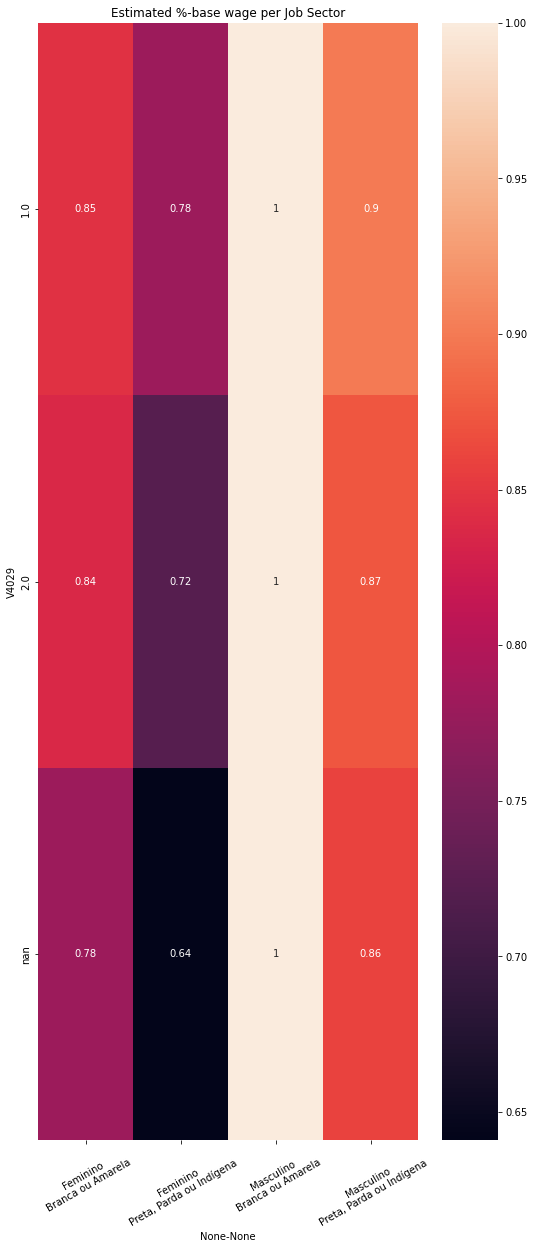

In [426]:
d = pd.DataFrame(deltas[msk]).drop(columns= ['log_wage']).groupby(data[test_msk].reset_index()['V4029'][msk].astype(str)).median()
    
sns.heatmap(
    d,
    yticklabels = d.index,
    xticklabels = ['\n'.join(i) for i in d.columns],
    annot = True
)

plt.subplots_adjust(-.2,-3)
plt.xticks(rotation=30)
plt.title('Estimated %-base wage per Job Sector')

In [427]:
#permutation importance of deltas
var_dict[var_dict['Categorias Descrição'].str.contains('filh').fillna(False)]

,Posição inicial,Tamanho,quesito nº,Quesito Descrição,Categorias Tipo,Categorias Descrição,Período,Parte
Código da variável,,,,,,,,
V4074,369.0,1.0,74,Qual foi o principal motivo de ... não ter tom...,5,"Tinha que cuidar de filho(s), de outro(s) depe...",1º tri/2012 - 3º tri/2015,3 - Pessoas não ocupadas
V4074A,370.0,2.0,74A,Qual foi o principal motivo de ... não ter tom...,07,"Tinha que cuidar dos afazeres domésticos, do(s...",4º tri/2015 - atual,3 - Pessoas não ocupadas
V4078,383.0,1.0,78,Qual foi o principal motivo para ... não quere...,1,"Tinha que cuidar de filho(s), de outro(s) depe...",1º tri/2012 - 3º tri/2015,3 - Pessoas não ocupadas
V4078A,384.0,1.0,78A,Qual foi o principal motivo para ... não quere...,1,"Tinha que cuidar dos afazeres domésticos, do(s...",4º tri/2015 - atual,3 - Pessoas não ocupadas
VD4023,446.0,1.0,82,Motivo pelo qual não procurou trabalho ou não ...,1,"Tinha que cuidar dos afazeres domésticos, do(s...",1º tri/2012 - 3º tri/2015,Variáveis Derivadas
VD4030,447.0,1.0,82,Motivo pelo qual não procurou trabalho ou não ...,1,"Tinha que cuidar dos afazeres domésticos, do(s...",4º tri/2015 - atual,Variáveis Derivadas
